In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from pydicom import dcmread
from skimage.io import imsave, imread
from skimage.transform import resize
from tqdm import tqdm
import ast, sys
from functools import partial

sys.path.append("/home/moritz/repositories/fair_leak/")
np.random.seed(420)
tqdm.pandas()
FONTSIZE=9
plt.rcParams.update(
    {"font.size": FONTSIZE})

In [3]:
data_root = Path("/home/moritz/data_big/fairvision/FairVision")
glaucoma_df = pd.read_csv(data_root / "Glaucoma/ReadMe/data_summary_glaucoma.csv")
dr_df = pd.read_csv(data_root / "DR/ReadMe/data_summary_dr.csv")
amd_df = pd.read_csv(data_root / "AMD/ReadMe/data_summary_amd.csv")

In [4]:
glaucoma_df

,filename,age,gender,race,ethnicity,language,maritalstatus,md,glaucoma,use
0,data_00001.npz,38.59,female,asian,non-hispanic,english,married or partnered,0.57,no,training
1,data_00002.npz,56.82,female,white,non-hispanic,english,married or partnered,-3.63,yes,training
2,data_00003.npz,34.60,female,white,non-hispanic,english,single,-0.47,no,training
3,data_00004.npz,79.82,female,black,non-hispanic,english,divorced,-8.58,yes,training
4,data_00005.npz,56.51,male,white,non-hispanic,english,divorced,-3.89,yes,training
...,...,...,...,...,...,...,...,...,...,...
9995,data_09996.npz,49.62,female,white,non-hispanic,english,single,0.63,no,test
9996,data_09997.npz,20.57,female,black,non-hispanic,english,single,-0.94,no,test
9997,data_09998.npz,86.05,female,white,non-hispanic,english,widowed,-6.48,yes,test
9998,data_09999.npz,39.98,male,asian,non-hispanic,english,single,-0.68,no,test


In [5]:
def add_path(row: pd.Series, prefix:str) -> pd.Series:
    split = row['use'].title()
    patient_id_prefix = prefix.lower()[0]
    patient_id = row['filename'].split("_")[1].split(".")[0]
    row['oct_file_path'] = f"./{prefix}/{split}/{row['filename']}"
    row['slo_file_path'] = f"./{prefix}/{split}/slo_fundus_{patient_id}.jpg"
    row['patient_id'] = f"{patient_id_prefix}_{patient_id}"
    return row
# Glaucoma df
glaucoma_df = glaucoma_df.apply(partial(add_path, prefix="Glaucoma"), axis=1)
# DR df
dr_df = dr_df.apply(partial(add_path, prefix="DR"), axis=1)
# AMD df
amd_df = amd_df.apply(partial(add_path, prefix="AMD"), axis=1)

In [6]:
merged_data = pd.concat([glaucoma_df, dr_df, amd_df])

In [7]:
# check all files exist
for path in tqdm(merged_data.slo_file_path):
    assert (data_root/path).exists(), f"Couldn't find image {data_root/path}"
for path in tqdm(merged_data.oct_file_path):
    assert (data_root/path).exists(), f"Couldn't find image {data_root/path}"

100%|██████████| 30000/30000 [00:00<00:00, 155579.31it/s]


In [8]:
merged_data

,filename,age,gender,race,ethnicity,language,maritalstatus,md,glaucoma,use,oct_file_path,slo_file_path,patient_id,dr,amd
0,data_00001.npz,38.59,female,asian,non-hispanic,english,married or partnered,0.57,no,training,./Glaucoma/Training/data_00001.npz,./Glaucoma/Training/slo_fundus_00001.jpg,g_00001,NaN,NaN
1,data_00002.npz,56.82,female,white,non-hispanic,english,married or partnered,-3.63,yes,training,./Glaucoma/Training/data_00002.npz,./Glaucoma/Training/slo_fundus_00002.jpg,g_00002,NaN,NaN
2,data_00003.npz,34.60,female,white,non-hispanic,english,single,-0.47,no,training,./Glaucoma/Training/data_00003.npz,./Glaucoma/Training/slo_fundus_00003.jpg,g_00003,NaN,NaN
3,data_00004.npz,79.82,female,black,non-hispanic,english,divorced,-8.58,yes,training,./Glaucoma/Training/data_00004.npz,./Glaucoma/Training/slo_fundus_00004.jpg,g_00004,NaN,NaN
4,data_00005.npz,56.51,male,white,non-hispanic,english,divorced,-3.89,yes,training,./Glaucoma/Training/data_00005.npz,./Glaucoma/Training/slo_fundus_00005.jpg,g_00005,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,data_09996.npz,86.04,female,white,non-hispanic,english,married or partnered,NaN,NaN,test,./AMD/Test/data_09996.npz,./AMD/Test/slo_fundus_09996.jpg,a_09996,NaN,intermediate amd
9996,data_09997.npz,74.32,male,white,non-hispanic,english,unknown,NaN,NaN,test,./AMD/Test/data_09997.npz,./AMD/Test/slo_fundus_09997.jpg,a_09997,NaN,late amd
9997,data_09998.npz,64.57,female,white,non-hispanic,english,married or partnered,NaN,NaN,test,./AMD/Test/data_09998.npz,./AMD/Test/slo_fundus_09998.jpg,a_09998,NaN,normal
9998,data_09999.npz,60.38,female,white,non-hispanic,english,married or partnered,NaN,NaN,test,./AMD/Test/data_09999.npz,./AMD/Test/slo_fundus_09999.jpg,a_09999,NaN,normal


## Automatic quality control

In [9]:
# this will take a while but only needs to be done once
def img_stats(row:pd.Series):
    img = imread(data_root / row['slo_file_path'])
    row['img_mean'] = img.mean()
    row['img_std'] = img.std()
    return row
merged_data = merged_data.progress_apply(img_stats, axis=1)

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [12:43<00:00, 39.27it/s]


Text(0.5, 1.0, 'Image std')

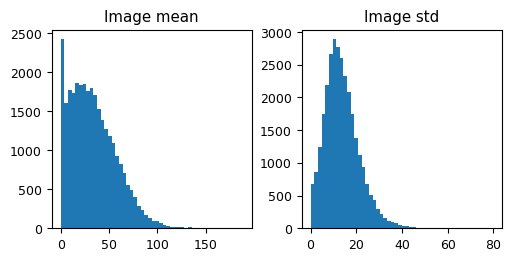

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(5, 2.5), layout='constrained')
n_bins=50
axes[0].hist(merged_data.img_mean, bins=n_bins)
axes[0].set_title("Image mean")
axes[1].hist(merged_data.img_std, bins=n_bins)
axes[1].set_title("Image std")

In [ ]:
exclude = (merged_data.img_std <= 3) | (merged_data.img_mean <= 1)
print(f"{sum(exclude)} images match the quality control exclusion criteria.")

1458 images match the quality control exclusion criteria.


/home/moritz/miniconda3/envs/fair_leak/lib/python3.9/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


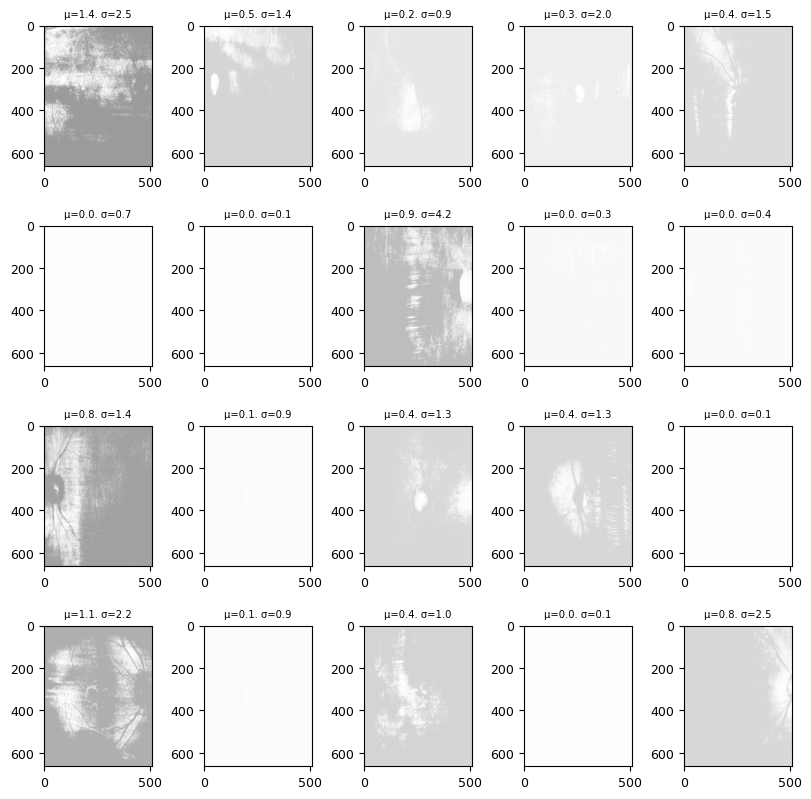

In [12]:
from skimage import exposure
N, M = 4, 5
fig, axes = plt.subplots(N, M, figsize=(8, 8), layout="constrained")
trash = merged_data[exclude]
for ax in axes.flat:
    row = trash.sample()
    img_path = row['slo_file_path'].values[0]
    img = np.array(imread(data_root / img_path), dtype=np.float32)
    img /= 255.0
    img = exposure.equalize_hist(img)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"μ={row['img_mean'].values[0]:.1f}. σ={row['img_std'].values[0]:.1f}",fontsize=0.8*FONTSIZE)

In [13]:
merged_data = merged_data[~exclude]
print(f"{len(merged_data)} images remaining")

28542 images remaining


## Visualising some random samples

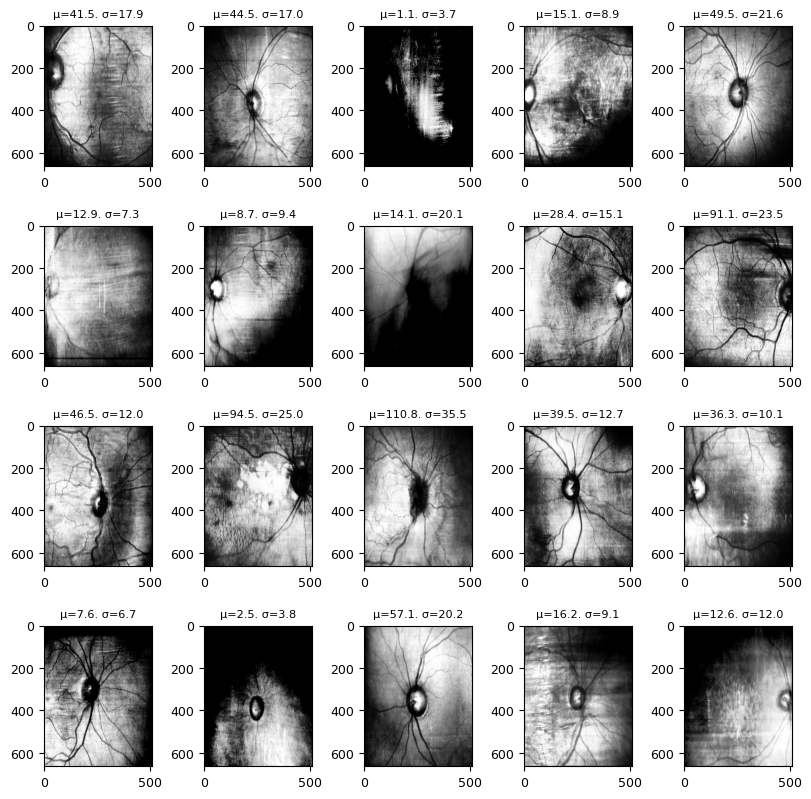

In [14]:
from skimage import exposure
N, M = 4, 5
fig, axes = plt.subplots(N, M, figsize=(8, 8), layout="constrained")
for ax in axes.flat:
    row = merged_data.sample()
    img_path = row['slo_file_path'].values[0]
    img = np.array(imread(data_root / img_path), dtype=np.float32)[..., 0]
    img /= 255.0
    img = exposure.equalize_hist(img)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"μ={row['img_mean'].values[0]:.1f}. σ={row['img_std'].values[0]:.1f}",fontsize=0.9*FONTSIZE)

## Disease information processing

In [ ]:
merged_data.dr.value_counts(normalize=True, dropna=False)

dr
NaN                          0.667052
non-vision threatening dr    0.304358
vision threatening dr        0.028589
Name: proportion, dtype: float64

In [16]:
merged_data.amd.value_counts(normalize=True, dropna=False)

amd
NaN                 0.665931
normal              0.213930
late amd            0.049821
intermediate amd    0.040081
early amd           0.030236
Name: proportion, dtype: float64

In [17]:
merged_data.glaucoma.value_counts(normalize=True, dropna=False)

glaucoma
NaN    0.667017
no     0.172903
yes    0.160080
Name: proportion, dtype: float64

In [18]:
merged_data['disease'] = "Placeholder"
na_dr = merged_data.dr.isna()
na_amd = merged_data.amd.isna()
na_glauc = merged_data.glaucoma.isna()
merged_data.loc[~na_dr, 'disease'] = merged_data.loc[~na_dr, 'dr']
merged_data.loc[~na_amd, 'disease'] = merged_data.loc[~na_amd, 'amd']
merged_data.loc[~na_glauc, 'disease'] = merged_data.loc[~na_glauc, 'glaucoma']

In [19]:
merged_data.disease = merged_data.disease.replace({"normal":"healthy", "no":"healthy", "yes":"glaucoma"}) 

In [20]:
merged_data["disease_label"] = merged_data.disease
merged_data["disease_label"] = merged_data.disease_label.replace({"healthy":0, "non-vision threatening dr":1, "vision threatening dr":2, "glaucoma":3, "early amd":4, "intermediate amd":5, "late amd":6}) 

/tmp/ipykernel_2141034/1128615771.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data["disease_label"] = merged_data.disease_label.replace({"healthy":0, "non-vision threatening dr":1, "vision threatening dr":2, "glaucoma":3, "early amd":4, "intermediate amd":5, "late amd":6})


In [21]:
merged_data.disease.value_counts(normalize=True, dropna=False), merged_data.disease_label.value_counts(normalize=True, dropna=False)

(disease
 healthy                      0.386833
 non-vision threatening dr    0.304358
 glaucoma                     0.160080
 late amd                     0.049821
 intermediate amd             0.040081
 early amd                    0.030236
 vision threatening dr        0.028589
 Name: proportion, dtype: float64,
 disease_label
 0    0.386833
 1    0.304358
 3    0.160080
 6    0.049821
 5    0.040081
 4    0.030236
 2    0.028589
 Name: proportion, dtype: float64)

## Train-test split

In [22]:
merged_data.use.value_counts(normalize=True, dropna=False)

use
training      0.600764
test          0.299909
validation    0.099327
Name: proportion, dtype: float64

In [35]:
merged_data.use.value_counts(dropna=False)

use
training      17147
test           8560
validation     2835
Name: count, dtype: int64

In [25]:
#merged_data.to_csv("/home/moritz/repositories/med_leak/data/csv/fairvision.csv")